<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General</a></span></li></ul></div>

Calculation for a CPW where the center conductor is made up of unit cells of series L+Lj and a capacitance to ground, using the **alternative** model.

We downscale the CPW because we want the unit cells to be as small as possible. We choose a unit cell length of 1um and for this we shrink the CPW by a factor of 10. CPW parameters are calculated with the following code:

```python
from tlineformulas import getlinepars
geo = {'s': 1e-6, 'w': .6e-6, 't': 80e-9, 'london': 158e-9, 'epsr': 11.9}
tlpars = getlinepars(geo)
[print(str(key)+':', val) for key, val in tlpars.items()]
print()
```

# General

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle
c = const.c
pi = np.pi
e = const.e
hbar = const.hbar
h = const.Planck
Phi0 = h/(2*e)

In [2]:
# Cavity parameters (per length)

Cg = 1.6940741661078421e-10 # geometric capacitance, in F/m
Lg = 4.23629201431845e-07 # geometric inductance, in H/m
Lk = 4.188210237203963e-07 # kinetic inductance, in H/m
Lprime = Lg+Lk # linear inductance, in H/m
Cprime = Cg # capacitance, in F/m

# Additional parameters
Cs = 24e-12 # shunt capacitor, in F
Ic = 9.176e-6 # critical current, in A

In [5]:
# variables:
# I - bias current, in A
# Ic - critical current, in A
# l - unit cell length, in m
# f0fix - intended zero-bias resonance frequency, in Hz
# N - total number of unit cells, dimensionless

def Lj(I=0,Ic=9.176e-6):
    # Josephson inductance of a single junction, also per unit cell, in H
    return Phi0/(2*pi*np.sqrt(Ic**2-I**2))

def Ln(I=0,Ic=9.176e-6,l=1e-6):
    # inductance per unit cell, in H
    return Lprime*l + Lj(I,Ic)

def Lambda(Ic=9.176e-6,l=1e-6):
    # linear inductance per unit cell inductance, dimensionless
    return Lprime*l/Ln(I=0,Ic=Ic,l=l)

def w0(I=0,Ic=9.176e-6,l=1e-6,f0fix=7.5e9,N=1):
    # resonance frequency, in 2pi*Hz
    return w0n(Ic=Ic,l=l,N=N)/np.sqrt(Lambda(Ic=Ic,l=l) + (1-Lambda(Ic=Ic,l=l))/np.sqrt(1-I**2/Ic**2))

def w0n(Ic=9.176e-6,l=1e-6,N=1):
    return pi/(N*l)*1/np.sqrt(Cprime*Ln(I=0,Ic=Ic,l=l)/l)

def ln(Ic=9.176e-6,N=1,f0fix=7.5e9):
    # unit cell length, as a function of number of unit cells, in m
    w0fix = 2*pi*f0fix
    top = -Lj(I=0,Ic=Ic)+np.sqrt( Lj(I=0,Ic=Ic)**2 + 4*Lprime*pi**2/(N**2 * w0fix**2 * Cprime) )
    bottom = 2*Lprime
    return top/bottom

def Nl(Ic=9.176e-6,l=1e-6,f0fix=7.5e9):
    # number of unit cells, as a function of unit cell length, dimensionless
    w0fix = 2*pi*f0fix
    top = pi
    bottom = w0fix*l*np.sqrt(Cprime*Ln(I=0,Ic=Ic,l=l)/l)
    return np.around(top/bottom).astype(int)

In [12]:
# Anharmonicity
# Alternative formulas

def xi(I=0,Ic=9.176e-6,l=1e-6,f0fix=7.5e9,N=1):
    # anharmonicity, in 2pi*Hz
    return e**2 * w0(I=I,l=l,N=N)**2 / (16*hbar * N) * Lj(I=I,Ic=Ic)**3 / Ln(I=I,Ic=Ic,l=l)**2

def anh(I=0,Ic=9.176e-6,l=1e-6,f0fix=7.5e9,N=1):
    return 12*xi(I=I,Ic=Ic,l=l,f0fix=f0fix,N=N)/2/pi

In [8]:
ii = np.linspace(0,9e-6,201) # all bias currents, in A
nn = np.unique(np.around(np.logspace(0,3.5,201)).astype(int)) # total number of unit cells, dimensionless
ll = ln(N=nn) # all unit cell lengths, in m
print("Number of unit cells")
f_of_n = w0n(l=ll,N=nn)/2/pi

Number of unit cells


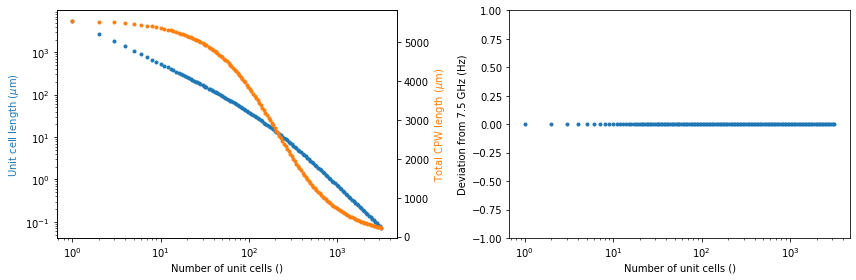

In [10]:
fig,(axa,axb)=plt.subplots(1,2,figsize=(12,4))

plt.sca(axa)
plt.plot(nn,ll/1e-6,'C0.')
plt.yscale('log')
plt.xlabel('Number of unit cells ()')
plt.ylabel('Unit cell length (µm)',c='C0')
ax2 = plt.gca().twinx()
plt.plot(nn,ll*nn/1e-6,'C1.')
plt.ylabel('Total CPW length (µm)',c='C1')
# plt.yscale('log')
plt.xscale('log')
# plt.grid(which='both')

plt.sca(axb)
plt.plot(nn,(f_of_n-7.5e9),'.')
plt.xlabel('Number of unit cells ()')
plt.ylabel('Deviation from 7.5 GHz (Hz)')
plt.ylim(-1,1)
plt.xscale('log')

plt.tight_layout()

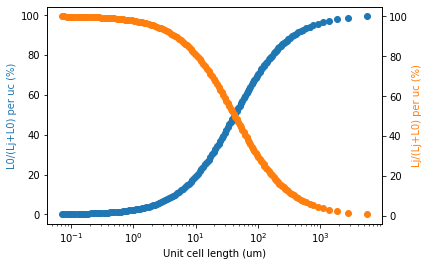

In [11]:
plt.plot(ll/1e-6,Lambda(l=ll)*100,'C0o')
plt.xscale('log')
plt.xlabel('Unit cell length (um)')
plt.ylabel('L0/(Lj+L0) per uc (%)',c='C0')
ax2 = plt.gca().twinx()
plt.plot(ll/1e-6,(1-Lambda(l=ll))*100,'C1o')
plt.ylabel('Lj/(Lj+L0) per uc (%)',c='C1')
plt.show()
plt.close()

In [16]:
X,Yn = np.meshgrid(ii,nn)
X,Yl = np.meshgrid(ii,ll)

In [13]:
Anh = np.array([anh(I=ii,Ic=Ic,l=l,N=N) for l,N in zip(ll,nn)])
Anh_linecut = Anh[:,0]

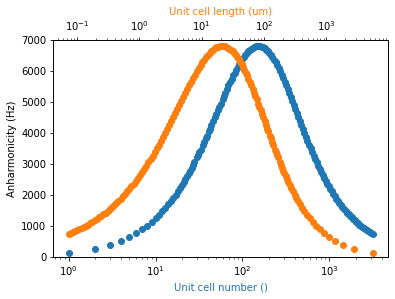

In [14]:
fig,ax1 = plt.subplots(1,1)
plt.ylabel('Anharmonicity (Hz)')
# plt.grid(which='both',c='C0')
ax2 = ax1.twiny()
line1, = ax1.plot(nn,Anh_linecut,'C0o',label='N')
line2, = ax2.plot(ll/1e-6,Anh_linecut,'C1o',label='l')
ax1.set_xscale('log')
ax1.set_xlabel('Unit cell number ()',color='C0')
ax2.set_xscale('log')
ax2.set_xlabel('Unit cell length (um)',color='C1')
# plt.grid(which='both',c='C1')
plt.ylim(0,7e3)
plt.show()
plt.close()

In [18]:
fmcurrs = w0(I=X,Ic=Ic,l=Yl,N=Yn)/2/pi

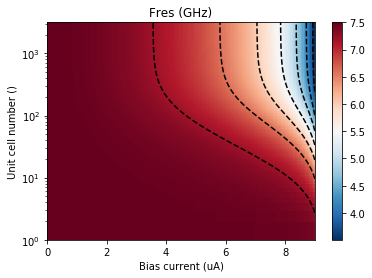

In [19]:
plt.contour(X/1e-6,Yn,fmcurrs/1e9,colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yn,fmcurrs/1e9,cmap='RdBu_r')
plt.colorbar()
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell number ()')
plt.title('Fres (GHz)')
plt.show()
plt.close()

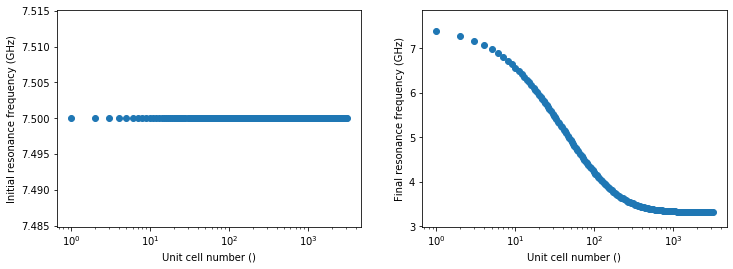

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
# plt.axhline(7.5,c='C1')
plt.scatter(nn,fmcurrs[:,0]/1e9)
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('Initial resonance frequency (GHz)')
plt.sca(ax2)
plt.scatter(nn,fmcurrs[:,-1]/1e9)
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('Final resonance frequency (GHz)')
plt.ylim(np.min(fmcurrs)/1e9*0.9,np.max(fmcurrs)/1e9*1.05)
# plt.ylim(5.2,7.5)
plt.show()
plt.close()

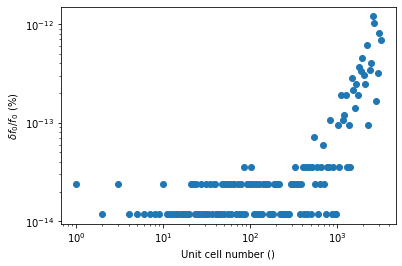

In [22]:
plt.plot(nn,abs(fmcurrs[:,0]/1e9-7.5)/7.5*100,'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Unit cell number ()')
plt.ylabel('$\delta f_0/f_0$ (%)')
plt.show()
plt.close()

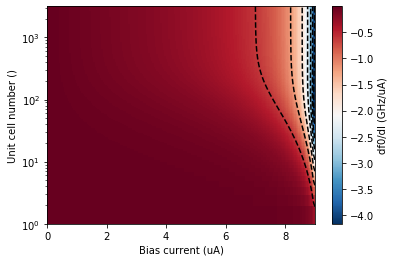

In [23]:
G1 = np.gradient(fmcurrs,axis=1)/np.gradient(X)[1]
plt.contour(X/1e-6,Yn,G1/(1e9/1e-6),colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yn,G1/(1e9/1e-6),cmap='RdBu_r')
plt.colorbar(label='df0/dI (GHz/uA)')
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell number ()')
#plt.grid()#which='both')
plt.show()
plt.close()

In [37]:
# for l=1um
myl = 1e-6
myn = Nl(l=myl)
print(myl, myn)
myanh = anh(I=ii,Ic=Ic,l=myl,N=myn)

1e-06 845


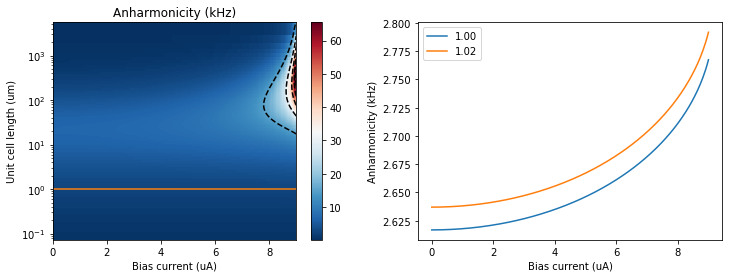

In [26]:
idx = 111

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
plt.contour(X/1e-6,Yl/1e-6,Anh/1e3,colors='k',linestyles='dashed')
plt.pcolormesh(X/1e-6,Yl/1e-6,Anh/1e3,cmap='RdBu_r')
plt.axhline(Yl[idx,0]/1e-6,c='tab:orange')
plt.colorbar()
plt.yscale('log')
plt.xlabel('Bias current (uA)')
plt.ylabel('Unit cell length (um)')
plt.title('Anharmonicity (kHz)')
plt.sca(ax2)
plt.plot(ii/1e-6,myanh/1e3,label='%.2f' % (myl/1e-6))
plt.plot(X[idx,:]/1e-6,Anh[idx,:]/1e3,label='%.2f' % (Yl[idx,0]/1e-6))
plt.legend()
plt.xlabel('Bias current (uA)')
plt.ylabel('Anharmonicity (kHz)')
plt.show()
plt.close()

In [28]:
import pickle
# Export the 1um anharmonicity
myf0 = w0(I=ii,Ic=Ic,l=myl,N=myn)/2/pi
mydict = {'l':myl,'N':myn,'I':ii,'Anh':myanh,'f0':myf0}
pickle.dump(mydict,open('data_processed/JJarrayCPW_alternative_1um_pars.pkl','wb'))

In [29]:
import stlabutils
import pandas as pd
import pickle

zvals = [Anh,fmcurrs]
ztitles = ['Anharmonicity (Hz)','Resonance frequency (Hz)']
shortkeys = ['Anh','f0']
for shortkey,zval,ztitle in zip(shortkeys,zvals,ztitles):
    mydf = pd.DataFrame(zval,columns=ii)
    mymtx = stlabutils.utils.stlabdict.stlabmtx(mydf,
                                                xtitle='Bias current (A)',
                                                ytitle='Index ()',
                                                ztitle=ztitle)

    mymtx.savemtx('data_processed/JJarrayCPW_alternative_1um'+shortkey)
    mypkl = [X,Yn,Yl,zval]
    pickle.dump(mypkl,open('data_processed/JJarrayCPW_alternative_1um'+shortkey+'.pkl','wb'))

(145, 201)
29145
(145, 201)
29145


In [30]:
pkl_main = pickle.load(open('data_final/fig2_panel_f0fit.pkl', 'rb'))
pkl_JJCPW = pickle.load(open('data_processed/JJarrayCPW_alternative_1um_pars.pkl', 'rb'))

In [31]:
pkl_JJCPW.keys(),pkl_main.keys()

(dict_keys(['l', 'N', 'I', 'Anh', 'f0']),
 dict_keys(['x1', 'y1', 'label', 'xtheo', 'ytheo', 'xlabel', 'ylabel', 'params']))

In [32]:
Ib = pkl_JJCPW['I']
f0_JJCPW = pkl_JJCPW['f0']

In [33]:
from src.model_currentbias import f0 as f0model
params_main = pkl_main['params']

In [34]:
params_main

Parameters([('fr',
             <Parameter 'fr', value=7514793068.270155 +/- 2.93e+05, bounds=[-inf:inf]>),
            ('Lr',
             <Parameter 'Lr', value=3.4579690944669516e-09 +/- 1.36e-11, bounds=[-inf:inf]>),
            ('Ic',
             <Parameter 'Ic', value=9.176089241631507e-06 +/- 4.51e-09, bounds=[-inf:inf]>),
            ('nJJ', <Parameter 'nJJ', value=1 (fixed), bounds=[-inf:inf]>)])

In [35]:
f0_main = f0model(Ib,fr = params_main['fr'],Lr=params_main['Lr'],Ic=params_main['Ic'])

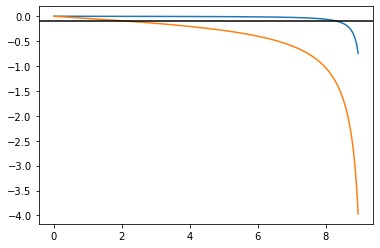

In [36]:
imax = 1
plt.plot(Ib[:-imax]/1e-6,np.gradient(f0_main/1e9,Ib/1e-6)[:-imax])
plt.plot(Ib[:-imax]/1e-6,np.gradient(f0_JJCPW/1e9,Ib/1e-6)[:-imax])
plt.axhline(-0.1,c='k')